In [1]:
# Import Statements

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.utils.openpy import source_to_unicode
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
# CSV to Dict Function

def csv_to_dict(input_file):
    file = open(input_file)
    reader = csv.reader(file)
    data = list(reader)
    file.close()
    
    csv_data = data
    csv_header = csv_data[0]
    csv_rows = csv_data[1:]
    
    output_dict = dict()
    for idx in range(len(csv_rows)):
        output_dict[csv_rows[idx][0]] = csv_rows[idx][1:]
    return output_dict

In [3]:
# CSV to List Function

def csv_to_list(input_file):
    file = open(input_file)
    reader = csv.reader(file)
    data = list(reader)
    file.close()
    csv_rows = data[1:]
    return csv_rows

In [4]:
# CSVs to Dicts

opr_dict = csv_to_dict("opr_by_team.csv")
for team in opr_dict:
    opr_dict[team] = float(opr_dict[team][0])

number_to_name = csv_to_dict("number_to_name.csv")
placement_rankings = csv_to_dict("placement_rankings.csv")
for team in placement_rankings:
    placement_rankings[team] = placement_rankings[team][0]

In [5]:
# CSVs to Lists

red_teams = csv_to_list("red_matches.csv")
blue_teams = csv_to_list("blue_matches.csv")

In [6]:
# Teams to Match Dictionary:

match_dict = dict()
for idx in range(len(red_teams)):
    match_list = list()
    match_list.append(red_teams[idx])
    match_list.append(blue_teams[idx])
    match_dict["Match " + str(idx + 1)] = match_list

In [7]:
# Bucketize by Matches Function

def bucketize_by_match(team_number):
    bucket_list = list()
    for match in match_dict:
        if team_number in match_dict[match][0] or team_number in match_dict[match][1]:
            bucket_list.append(match)
    return bucket_list

In [8]:
# Average OPR per Team

def average_opr(team_number):
    adjusted_opr_per_match = dict()
    total_opr = 0
    count = 0
    for match in bucketize_by_match(team_number):
        if team_number in match_dict[match][0][0]:
            adjusted_opr_per_match[match] = opr_dict[match_dict[match][0][1]] - (opr_dict[match_dict[match][1][0]] + opr_dict[match_dict[match][1][1]])
        if team_number in match_dict[match][0][1]:
            adjusted_opr_per_match[match] = opr_dict[match_dict[match][0][0]] - (opr_dict[match_dict[match][1][0]] + opr_dict[match_dict[match][1][1]])
        if team_number in match_dict[match][1][0]:
            adjusted_opr_per_match[match] = opr_dict[match_dict[match][1][1]] - (opr_dict[match_dict[match][0][0]] + opr_dict[match_dict[match][0][1]])
        if team_number in match_dict[match][1][1]:
            adjusted_opr_per_match[match] = opr_dict[match_dict[match][1][0]] - (opr_dict[match_dict[match][0][0]] + opr_dict[match_dict[match][0][1]])
    for match in adjusted_opr_per_match:
        total_opr += adjusted_opr_per_match[match]
        count += 1
    return total_opr/count

In [9]:
# Average OPR dictionary

average_opr_dict = dict()
for team in opr_dict:
    average_opr_dict[team] = average_opr(team)
average_opr_dict = sorted(average_opr_dict.items(), key=lambda x:x[1], reverse = True)

In [10]:
# Full Rankings OPR Dict

ranked_average_opr_dict = dict()
count = 0
rank = 1
for team in average_opr_dict:
    team_list = list()
    team_list = [team[0], number_to_name[team[0]][0], average_opr_dict[count][1], placement_rankings[team[0]], rank]
    ranked_average_opr_dict[str(rank)] = team_list
    rank += 1
    count += 1
pretty_ranked_average_opr_dict = pd.DataFrame.from_dict(ranked_average_opr_dict, orient = "index")
pretty_ranked_average_opr_dict.columns = ["Team Number", "Team Name", "Average OPR", "Final Placement", "OPR Rank"]
print(pretty_ranked_average_opr_dict)

   Team Number                                          Team Name  \
1        15534                                             VERTEX   
2        18225                                    High Definition   
3        14361                               CPHS ROBOLOBOS GREEN   
4        14023                   SCHS Robotic Team - Phoenix Fire   
5        18492                              Mukhtar Robotics Team   
6        14212                                        Metrobotics   
7        19824                                     Pride Robotics   
8        19502                                  The Moment Makers   
9        22508                                          SUPERNOVA   
10       12887                                      Devolt Phobos   
11       18763                                            Texpand   
12       14140                                         Crash Test   
13       18317                                         Steel Eels   
14        9415                    

Text(0.5, 1.0, 'OPR Rank and Final Rank by Team Number')

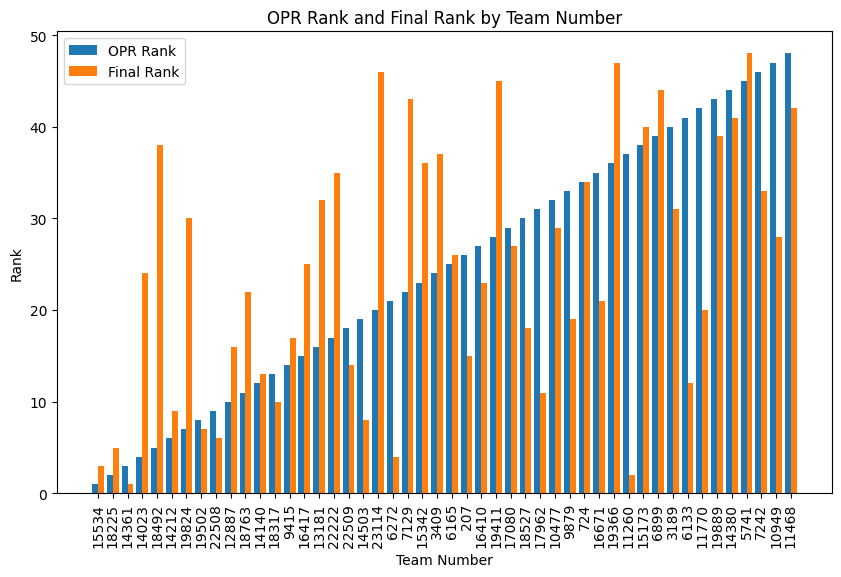

In [11]:
# Plotting Data
team_number = pretty_ranked_average_opr_dict["Team Number"]
final_placement = pretty_ranked_average_opr_dict["Final Placement"].astype(int)
opr_rank = pretty_ranked_average_opr_dict["OPR Rank"].astype(int)
array = np.arange(len(team_number))
size = 0.4
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(array - size/2, opr_rank, size, label = "OPR Rank")
ax.bar(array + size/2, final_placement, size, label = "Final Rank")
plt.xticks(array, team_number, rotation=90)
plt.ylabel("Rank")
plt.xlabel("Team Number")
plt.legend()
plt.title("OPR Rank and Final Rank by Team Number")

In [12]:
# Correlation
average_opr = pretty_ranked_average_opr_dict["Average OPR"]
X = average_opr.to_numpy()
X = X.flatten()
y = final_placement.to_numpy()
y = y.flatten()
correlation = np.corrcoef(X, y)[0, 1]
print(f"Correlation: {correlation}")

Correlation: -0.4886675766444241
